# Data Wrangling

This notebook will contain all of the code used to clean the Airbnb listings data within a pandas dataframe and engineer new features for the purpose of building a regression to predict the prices of Airbnb properties in London.

In [68]:
# importing the libraries/modules that will be used within this notebook

import pandas as pd
import geopy.distance
from geopy.extra.rate_limiter import RateLimiter
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import joblib

In [2]:
# opening the listings.csv document as a pandas dataframe

df = pd.read_csv("../data/july_6th/listings.csv")

Note: this project is now using the listings datasets uploaded to InsideAirbnb.com on July 6th.

In [3]:
# dataframe has 74 columns and 74840 rows

df.shape

(73364, 74)

## Data Cleaning

Directly below is an alphabetical list of the 74 columns that exist within the Airbnb listings dataset. In the following code, I'm going to decide which columns will be useful for this project, discard the columns that are irrelevant or duplicates and "clean" the columns that, in their current format (e.g. the price column has a dollar sign at the beginning of each value and is thus stored as a piece of text rather than a number), can't be used for modelling purposes. 

In [4]:
sorted(list(df.columns))

['accommodates',
 'amenities',
 'availability_30',
 'availability_365',
 'availability_60',
 'availability_90',
 'bathrooms',
 'bathrooms_text',
 'bedrooms',
 'beds',
 'calculated_host_listings_count',
 'calculated_host_listings_count_entire_homes',
 'calculated_host_listings_count_private_rooms',
 'calculated_host_listings_count_shared_rooms',
 'calendar_last_scraped',
 'calendar_updated',
 'description',
 'first_review',
 'has_availability',
 'host_about',
 'host_acceptance_rate',
 'host_has_profile_pic',
 'host_id',
 'host_identity_verified',
 'host_is_superhost',
 'host_listings_count',
 'host_location',
 'host_name',
 'host_neighbourhood',
 'host_picture_url',
 'host_response_rate',
 'host_response_time',
 'host_since',
 'host_thumbnail_url',
 'host_total_listings_count',
 'host_url',
 'host_verifications',
 'id',
 'instant_bookable',
 'last_review',
 'last_scraped',
 'latitude',
 'license',
 'listing_url',
 'longitude',
 'maximum_maximum_nights',
 'maximum_minimum_nights',
 'maxi

## Discarding columns

The first thing I'm going to do is discard the columns that I can immediately see won't be useful for modelling. 

The purpose of this project is to build a model to predict the prices of Airbnb properties that could be used by hosts when they list a new property. Since new properties aren't going to have any existing review data, I'm not going to be able use any review columns within the dataset to help predict their prices. All of the columns below are going to be discarded.

In [5]:
review_cols_drop = ['number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d',
                    'first_review', 'last_review', 'review_scores_rating',
                    'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin',
                    'review_scores_communication', 'review_scores_location',
                    'review_scores_value', 'reviews_per_month']

df.drop(review_cols_drop,axis=1,inplace=True)

Here are the columns related to the property host that I'm going to be dropping. Some of them are objectively useless as predictor variables (e.g. host_url, host_picture_url) and others are columns that I believe aren't useful (e.g. the name of the host or where they are based).

In [6]:
host_cols_drop = ['host_since', 'host_url', 'host_verifications', 'host_name', 'host_location',
                  'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
                  'host_listings_count', 'host_total_listings_count', 'calculated_host_listings_count_entire_homes',
                  'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms',]

df.drop(host_cols_drop,axis=1,inplace=True)

Below is a mish-mash of columns that either contain no values, are duplicates of other columns or, in my opinion, won't be useful predictor variables.

In [7]:
useless_cols_drop = ['scrape_id', 'last_scraped', 'picture_url', 'neighbourhood',
                     'neighbourhood_group_cleansed', 'bathrooms', 'minimum_nights',
                     'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights',
                     'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm',
                     'maximum_nights_avg_ntm', 'calendar_updated', 'has_availability',
                     'availability_30', 'availability_60', 'availability_90', 'availability_365',
                     'calendar_last_scraped', 'license']

df.drop(useless_cols_drop,axis=1,inplace=True)

Before I start any data cleaning, I'm going to rename a couple of the columns so that their titles make more sense.

In [8]:
df.rename(columns={'bathrooms_text': 'bathrooms', 'neighbourhood_cleansed': 'neighbourhood'},inplace=True)

## Filling null values

Let's have a look at the remaining columns that have null values.

In [9]:
null_values = pd.DataFrame(df.isnull().sum())
null_values = null_values[null_values[0] != 0]
null_values

,0
name,23
description,3189
neighborhood_overview,29528
host_about,33385
host_response_time,38307
host_response_rate,38307
host_acceptance_rate,37259
host_is_superhost,644
host_has_profile_pic,644
host_identity_verified,644


### Text Columns

For the text columns containing null values, I'm going to fill them in with the word 'null' to avoid having to remove these rows from my dataset. Later on this project, I'll be able to process this dataset so that these words are ignored by my model. 

In [10]:
# filling the null values in the following columns rather than removing any rows

df.name.fillna('null',inplace=True)
df.description.fillna('null',inplace=True)
df.neighborhood_overview.fillna('null',inplace=True)
df.host_about.fillna('null',inplace=True)

### Beds and bedrooms columns

To begin with, I'm going to deal with the bedrooms column as it contains more null values than the beds column. 

The assumption I'm making is that in the majority of the properties, the number of beds will match the number of bedrooms. As such, where the beds value is not null or 0, I'm going to use it to fill in the corresponding null bedrooms value. Where the beds value is null or zero, I'm going to fill it in with the median bedrooms value, which is 1, instead.

In [11]:
# filling in the null values in the bedrooms with the beds value, as these will generally be a straight match

def bedroom_cleaner(row):
    if np.isnan(row['bedrooms']) and row['beds'] != 0 and not np.isnan(row['beds']):
        return row['beds']
    else:
        return df.bedrooms.median()
    
df['bedrooms'] = df.apply(bedroom_cleaner,axis=1)

For the beds column, I'm just going to fill the null values with the column's median value of 1.

In [12]:
# filling null values in the beds column with the median values

df.beds.fillna(df.beds.median(),inplace=True)

I've created a function to allow me to look at the distribution of values in each variable

In [13]:
# # function for analysing a variable

# def variable_viewer(x):
#     values = df[x].value_counts(sort=False)
#     proportion = df[x].value_counts(sort=False,normalize='all')
#     variable_df = pd.DataFrame({'value_counts': values, 'proportion': proportion})
#     return variable_df.sort_values('value_counts', ascending=False)

### Converting true/false columns to binary values

For the columns containing 't' (true), 'f' (false) and null values. I'm going to convert them to contain binary values, where 1 represents true and 0 is false or null.

In [14]:
columns_to_binarise = ['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'instant_bookable']

In [15]:
for column in columns_to_binarise:
    df[column] = df[column].apply(lambda x: 1 if x=='t' else 0)

### Host response time

A larger number of the host response time values are null values. So we can one-hot encode this column for modelling, I'm going to convert the null values to 'unknown'.

In [16]:
df.host_response_time.value_counts(normalize='all',dropna=False)

NaN                   0.522150
within an hour        0.260196
within a few hours    0.094910
within a day          0.077245
a few days or more    0.045499
Name: host_response_time, dtype: float64

In [17]:
df.host_response_time.fillna('unknown',inplace=True)

### Host acceptance rate

Like previously, a lot of the values in the host acceptance rate column are null. This causes an issue as there are too many null values to fill with an aggregated value, but if we don't fill them, then we aren't able to use the non-null acceptance rates as they are.

The best solution in this instance is to categorize the values before one-hot encoding them. The Airbnb host guide (https://blog.atairbnb.com/hospitality-starts-with-accepting-reservations/) states that the top hosts have an acceptance rate of 75% or above, so I'll categorize the rates in my dataset depending on whether they're in this bracket or if they either aren't or are null. 

In [18]:
df.host_acceptance_rate.value_counts(normalize='all', dropna=False).head(10)

NaN     0.507865
100%    0.165572
0%      0.045363
97%     0.021755
99%     0.019724
50%     0.017979
95%     0.013072
98%     0.011777
96%     0.011722
67%     0.011395
Name: host_acceptance_rate, dtype: float64

In [19]:
df['host_acceptance_rate'] = df.host_acceptance_rate.str.replace('%','').fillna(np.nan).astype('float')

In [20]:
# function to categorize host acceptance rates

def host_filler(x):
    if not np.isnan(x) and x >= 75:
        return "Above or equal to 75%"
    else:
        return "Below 75% or not displayed"

In [21]:
df['host_acceptance_rate'] = df.host_acceptance_rate.apply(host_filler)

### Host response rate

Since the host response rate column has a similar issue as the host acceptance rate, it makes sense to solve it using the same method.

In [22]:
df.host_response_rate.value_counts(normalize='all', dropna=False).head(10)

NaN     0.522150
100%    0.298457
0%      0.030587
90%     0.014271
50%     0.009432
80%     0.008342
99%     0.008287
98%     0.008028
97%     0.007838
96%     0.006979
Name: host_response_rate, dtype: float64

In [23]:
# removing the % sign, filling null values with np.nan and converting the values to floats

df['host_response_rate'] = df.host_response_rate.str.replace('%','').fillna(np.nan).astype('float')

In [24]:
df['host_response_rate'] = df.host_response_rate.apply(host_filler)

### Bathrooms column

As the example below shows, the column showing the number of bathrooms in each property is stored as a text value. The code I've written beneath the example will convert the bathroom value from text to a float.

The null values are going to be filled in to match the number of bedrooms.

In [25]:
df.bathrooms.unique()

array(['1 bath', '1 shared bath', '2 baths', '1 private bath',
       '1.5 shared baths', '1.5 baths', '0 shared baths', nan,
       '2.5 shared baths', '2 shared baths', '2.5 baths',
       'Shared half-bath', '4 baths', '3 baths', '0 baths',
       '3 shared baths', '3.5 baths', 'Half-bath', '5 baths', '4.5 baths',
       '5 shared baths', '3.5 shared baths', 'Private half-bath',
       '7 baths', '4 shared baths', '6 shared baths', '6 baths',
       '5.5 baths', '10 baths', '8.5 baths', '7 shared baths',
       '6.5 baths', '8 shared baths', '17 baths', '7.5 baths', '8 baths',
       '10.5 baths', '4.5 shared baths', '12 baths', '9 baths',
       '9 shared baths', '6.5 shared baths', '10 shared baths',
       '18 shared baths'], dtype=object)

In [26]:
# function to check if string value is numeric

def is_number(x):
    try:
        float(x)
        return True
    except ValueError:
        return False

# function to convert bathrooms values in to floats and null values in to corresponding bedroom values

def bathroom_cleaner(row):
    if is_number(row['bathrooms']):
        return row['bedrooms']
    else:    
        split = row['bathrooms'].lower().split()
        if is_number(split[0]):
            return float(split[0])
        elif 'half-bath' in split:
            return float(0.5)
        else:
            return float(row['bathrooms'])

df['bathrooms'] = df.apply(bathroom_cleaner, axis=1)

### Re-checking for null values

No more columns with null values!

In [27]:
null_values = pd.DataFrame(df.isnull().sum())
null_values = null_values[null_values[0] != 0]
null_values

,0


## Dealing with columns on an individual basis

### Property type

At the moment the property type column contains too many variables, some with very few values. I don't think that this level of detail is necessary at all for my model. 

As the list below shows, the vast majority of properties are either an apartment or a house. Although there are quite a few edge categories (villa, boat, castle etc.), the number of these properties is tiny and won't make much of an effect when it comes to modelling.

In [28]:
df.property_type.value_counts().head(50)

Entire apartment                      29327
Private room in apartment             16955
Private room in house                 10401
Entire house                           5284
Entire condominium                     2335
Private room in townhouse              1459
Entire serviced apartment               966
Entire townhouse                        963
Private room in condominium             902
Private room in bed and breakfast       632
Room in hotel                           504
Room in boutique hotel                  470
Entire loft                             418
Shared room in apartment                278
Private room in loft                    233
Room in serviced apartment              211
Entire guest suite                      188
Private room in guest suite             170
Private room in guesthouse              165
Entire guesthouse                       128
Room in aparthotel                      117
Shared room in house                    113
Private room                    

To begin with, I'm going to separate properties in to a wide number of different categories.

In [29]:
# new property type categories

property_categories = ['apartment', 'house', 'townhouse', 'condominium',
                       'hotel', 'boutique hotel', 'bed and breakfast', 'loft',
                       'guest suite', 'guesthouse', 'private room', 'aparthotel',
                      'bungalow', 'hostel', 'boat', 'cottage', 'bungalow', 'villa', 'houseboat', 'other']

# function to sort the property column in to new categories

def property_simplifier(x):
    split = x.lower().split()
    if (' ').join(split[-3:]) in property_categories:
        return (' ').join(split[-3:])
    elif (' ').join(split[-2:]) in property_categories:
        return (' ').join(split[-2:])
    elif split[-1]=='houseboat':
        return 'boat'
    elif split[-1] in property_categories:
        return split[-1]
    else:
        return 'other'
    
# apply function to property_type column

property_type_simplified = df.property_type.apply(property_simplifier)

Now that the properies have been categorised, I'm going to split them in to 'house' and 'apartment' values.

In [30]:
apartment_cats = ['apartment', 'condominium', 'loft', 'guest suite', 'private room',
                  'hotel', 'boutique hotel', 'bed and breakfast', 'guest suite',
                  'aparthotel', 'hostel']

df['property_type_basic'] = property_type_simplified.apply(lambda x: "apartment" if x in apartment_cats else "house")

As we can see, there are a lot more apartment properties than houses.

In [31]:
df.property_type_basic.value_counts()

apartment    54224
house        19140
Name: property_type_basic, dtype: int64

### Amenities

The amenities column currently contains a list of every amenity that each property has. The Airbnb website allows hosts to choose from a pre-set amenity ( e.g. 'TV', 'Hair dryer', 'Kitchen' etc.) or a create a custom one. As a result of the custom option, some of the amenities are slightly untidy (there are a lot of variations on HDTV depending on the screen size!). 

Below is an example of a property's amenities list.

In [32]:
df.amenities[0]

'["Hot water", "Hair dryer", "Smoke alarm", "Fire extinguisher", "Oven", "Carbon monoxide alarm", "Kitchen", "Washer", "Crib", "Coffee maker", "Cooking basics", "Microwave", "Lockbox", "Heating", "TV with standard cable", "High chair", "Iron", "Dishes and silverware", "Essentials", "Stove", "Long term stays allowed", "Pack \\u2019n Play/travel crib", "Dedicated workspace", "Cable TV", "Refrigerator", "Hangers", "Wifi", "Paid parking off premises"]'

In [33]:
# creating a dictionary to store which amenities each property has

amenities_values = []

for amenities_list in df.amenities:
    if eval(amenities_list) != None:
        lst = eval(amenities_list)
        for value in lst:
            if value not in amenities_values:
                amenities_values.append(value)
            
amenities_dict = {}

for value in amenities_values:
    amenities_dict[value] = []    
    
for amenities_list in df.amenities:
    if eval(amenities_list) != None:
        lst = eval(amenities_list)
        for key in amenities_dict.keys():
            if key in lst:
                amenities_dict[key].append(1)
            else:
                amenities_dict[key].append(0)
    else:
        for key in amenities_dict.keys():
            amenities_dict[key].append(0)

In [34]:
# creating another dictionary to count how many times each amenity appears in the dataset

amenities_count_dict = {}

for key in amenities_dict.keys():
    amenities_count_dict[key] = sum(amenities_dict[key])

In [35]:
# creating a dictionary to show which amenities appear 500 times or more

over_500 = {}

for item in amenities_count_dict.keys():
    if amenities_count_dict[item] >= 500:
        over_500[item] = amenities_count_dict[item]

sorted(over_500.items())

[('Air conditioning', 5455),
 ('BBQ grill', 2735),
 ('Baby bath', 766),
 ('Baby safety gates', 556),
 ('Babysitter recommendations', 1489),
 ('Backyard', 10537),
 ('Baking sheet', 2053),
 ('Barbecue utensils', 809),
 ('Bathtub', 8541),
 ('Bed linens', 26834),
 ('Body soap', 3289),
 ('Breakfast', 9483),
 ('Building staff', 1702),
 ('Cable TV', 10680),
 ('Carbon monoxide alarm', 42496),
 ('Central heating', 849),
 ('Changing table', 642),
 ('Children’s books and toys', 2844),
 ('Children’s dinnerware', 1512),
 ('Cleaning before checkout', 2320),
 ('Cleaning products', 3061),
 ('Clothing storage', 1272),
 ('Clothing storage: closet', 691),
 ('Coffee maker', 16507),
 ('Conditioner', 2348),
 ('Cooking basics', 29038),
 ('Crib', 3578),
 ('Dedicated workspace', 43863),
 ('Dining table', 2877),
 ('Dishes and silverware', 30444),
 ('Dishwasher', 17529),
 ('Dryer', 31190),
 ('Drying rack for clothing', 2248),
 ('Elevator', 14705),
 ('Essentials', 66676),
 ('Ethernet connection', 3164),
 ('Extra 

Having looked through the list of amenities above, I've now created a list of categories that I'm hoping have an effect on the price of a property.

For each category, I'm going to a create a column in my dataset and use binary values to record whether each property has that amenity or category of amenities.

In [36]:
amenities_cats_dict = {'air_conditioning': 'air conditioning', 
                       'bbq': 'bbq',
                       'baby_facilities': 'baby|crib|changing table|high chair', 
                       'balcony_or_patio': 'patio|balcony',
                       'bath': 'bathtub|bath', 
                       'bed_linen': 'bed linens', 
                       'cable_tv': 'cable',
                       'child_friendly': 'children', 
                       'coffee_maker': 'coffee|nespresso', 
                       'cooking_facilities': 'oven|stove',
                       'dishwasher': 'dishwasher', 
                       'fridge_freezer': 'refrigerator|fridge|freezer',
                       'garden': 'backyard|garden', 
                       'has_workspace': 'workspace', 
                       'host_greets_you': 'host greets you',
                       'long_term_stays': 'long term stays allowed',
                       'luggage_dropoff': 'luggage dropoff', 
                       'lock_on_bedroom_door': 'lock on bedroom',
                       'luxury_facilities': 'gym|hot tub|pool|sauna', 
                       'private_entrance': 'private entrance',
                       'toiletries': 'soap|conditioner|shampoo|shower gel', 
                       'tumble_dryer': 'Dryer',
                       'tv': 'tv'}

for category in amenities_cats_dict.keys():
    if category == 'tumble_dryer':
        df.loc[df['amenities'].str.contains(amenities_cats_dict[category], case = True), category] = 1
        df.loc[~df['amenities'].str.contains(amenities_cats_dict[category], case = True), category] = 0
    else:    
        df.loc[df['amenities'].str.contains(amenities_cats_dict[category], case = False), category] = 1
        df.loc[~df['amenities'].str.contains(amenities_cats_dict[category], case = False), category] = 0

### Price

The first thing I'm going to do with the price column is convert the format of its values in to floats. At the moment, they are stored as text objects with '$' preceding the price and '.00' afterwards. I've included some examples below.

In [37]:
df.price.head()

0     $99.00
1     $65.00
2     $75.00
3    $307.00
4    $150.00
Name: price, dtype: object

In [38]:
df['price'] = df.price.str.replace('$','').str.replace('.00','').str.replace(',','').replace('',0).astype('float')

If we have a quick glance at the sorted values for price, we can see that at both ends there are some strange values. There obviously aren't going to be any Airbnb properties that are free to stay and, conversely, it feels very unlikely that there are any properties that cost thousands of pounds per night to stay at.

In [39]:
df.price.sort_values()

41650        0.0
4017         0.0
26678        0.0
9860         0.0
68315        0.0
          ...   
43031    15986.0
47204    15986.0
47214    15986.0
28354    17762.0
30601    17786.0
Name: price, Length: 73364, dtype: float64

Let's have a look at the price column within some visualisations to get an idea of how many properties have this extreme price values.

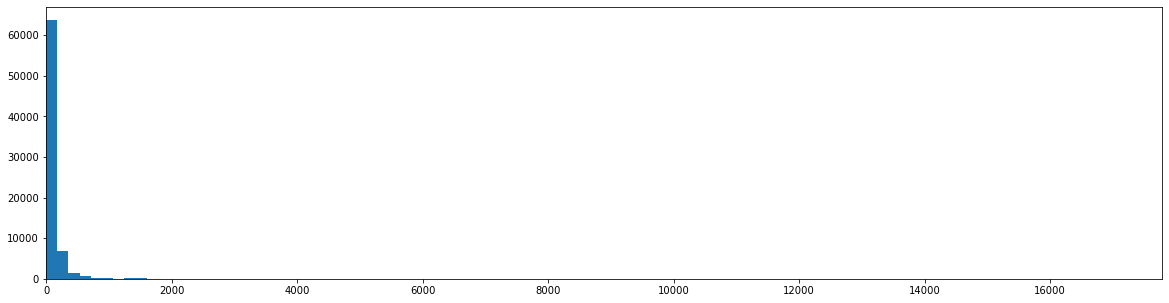

In [40]:
fig,ax = plt.subplots(figsize=(20,5))

plt.hist(df.price, bins=100)

plt.margins(x=0)
plt.show()

As the histogram above shows, the majority of our properties seem to be priced at around £1000 per night. There are some massive outliers, however, that are extending the graph horizontally with massively high prices. These extremely high prices are perhaps visualised better in the violinplot and rather squashed boxplot below.

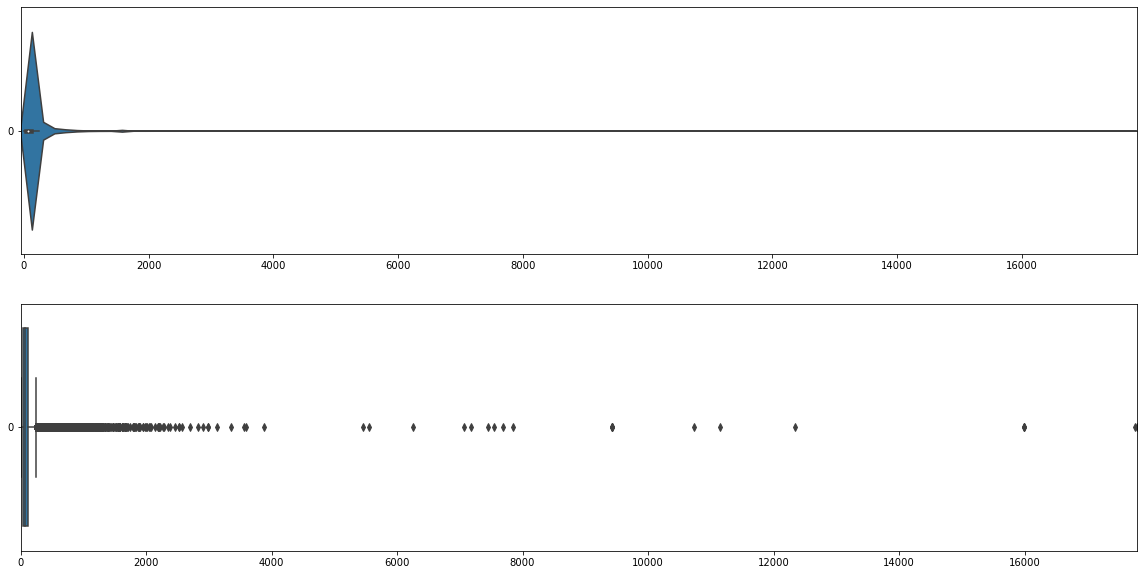

In [41]:
fig,ax = plt.subplots(nrows=2, figsize=(20,10))

sns.violinplot(data=df.price,orient='h',ax=ax[0])
sns.boxplot(data=df.price,orient='h',ax=ax[1])

ax[0].margins(x=0)
ax[1].margins(x=0)
plt.show()

One of the issues with this dataset is that it only contains the advertised price rather than the price actually paid by guests. As a result, some of these prices won't actually reflect the reality of what guests are willing to pay for them. Although there are a very small number of luxury Airbnb properties that can charge thousands of pounds per night, the properties in this dataset that have very high prices in no way warrant such an extraordinarily high cost.

My assumption is on one of the following:

- the hosts have priced the properties highly as they don't want guests to stay. By giving the properties a high price they aren't going to turn up in their searches. Perhaps this is easier for hosts to do than temporarily delist their properties?
- the prices have been entered by mistake. This seems less likely to me given the number of properties with a high or non-existent price, but it is possible given that the hosts are free to choose any price they want.

Let's have a look at the properties priced at under £2000 to get an idea of how the majority of the property prices are distributed.

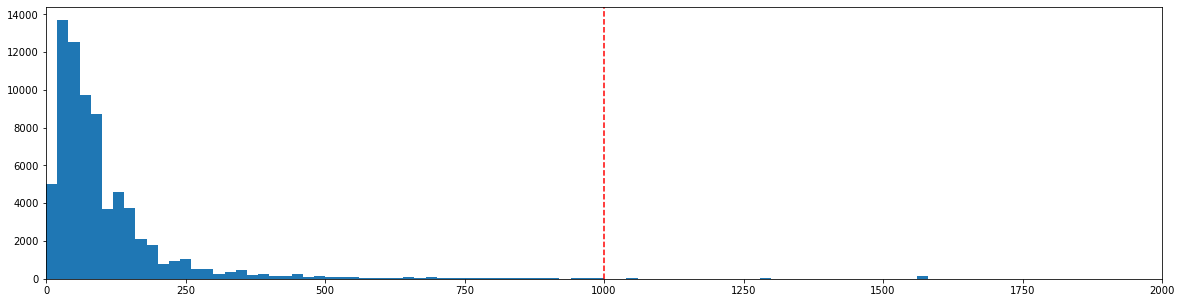

In [42]:
fig,ax = plt.subplots(figsize=(20,5))

plt.hist(df.price, bins=100, range=(0,2000))

plt.margins(x=0)

plt.axvline(1000, color='red', linestyle='--')
plt.show()

As the visualisation shows, the majority of properties seem to fall within the £1000 mark. In order to resolve the issue of properties with extremely inflated prices, I'm going to make the assumption that these properties are incorrectly priced and use £1000 as the max price for an Airbnb property in London. For properties that have very low prices, I'm going to set £20 as the min price. 

Like many similar solutions, this is imperfect and has its drawbacks. The main drawback is that there will be properties that legitimately cost more than £1000 and my model won't be able to predict their prices. I would argue, however, that this solution is for the greater good of the performance of the model given that properties priced so highly will be very rare.

In [43]:
# converting property prices lower than 20 to 20

df.loc[df.price < 20, 'price'] = 20

# converting property prices higher than 1000 to 1000

df.loc[df.price > 1000, 'price'] = 1000

Although there is now an unnatural group of properties that are priced at the £1000 mark, the price distribution overall looks more like one would expect it to look. This will be covered in slightly more detail during the EDA part of the project.

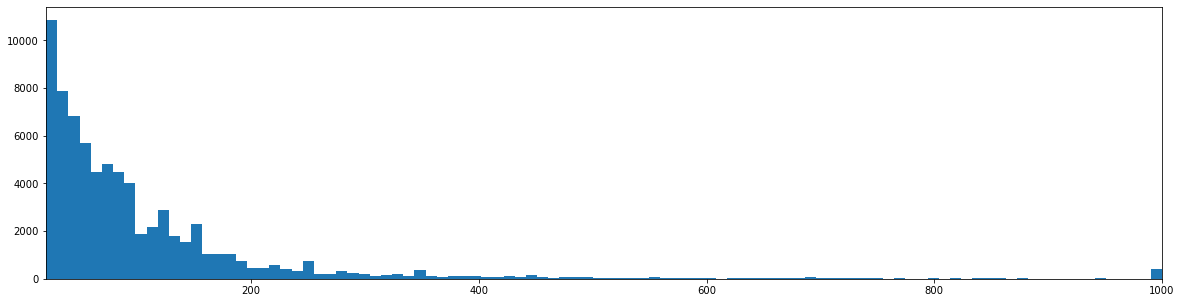

In [44]:
fig,ax = plt.subplots(figsize=(20,5))

plt.hist(df.price, bins=100)
plt.margins(x=0)

plt.show()

# Feature Engineering

Now to create some new features for our dataset! Hopefully these will improve the performance of the my model in determining how expensive a property should be.

#### Distance from "centre" of London

Under the assumption that most tourists in London would ideally want to be as close to the centre as possible, I'm going to create a new variable showing how far away from the centre of London each property is. Since there is no official centre of London, I'm going to use Trafalgar Square given that it is fairly geographically central and close to lots of popular tourist attractions.

In [45]:
# creating a variable to store the latitude and longitude values for Trafalgar Square

trafalgar_square = (51.5081073456795, -0.12808345704873553)

In [46]:
df['distance_from_center'] = df.apply(lambda row: geopy.distance.distance((row['latitude'],row['longitude']),trafalgar_square).km,axis=1)

#### Nearest train station

I'm also going to create a column showing how far the nearest train station is in km. This is being added under the assumption that if a property is a long way from a train station, then it is likely to be less desirable. 

In [47]:
stations = pd.read_csv('../data/Stations_20180921.csv')

Code to calculate the closest train station to each property and how far away it is in km.

In [48]:
# def station_checker(lat,long):
#     station = ''
#     station_distance = 1000
#     for station_,lat_, long_ in zip(stations.NAME,stations.y,stations.x):
#         calculated_distance = geopy.distance.distance((lat,long),(lat_,long_)).km
#         if calculated_distance < station_distance:
#             station_distance = calculated_distance
#             station = station_
#     return station, station_distance

Storing the results in a dictionary

In [49]:
# station_dict = {'index': [], 'nearest_station': [], 'station_distance': []}


# for i in df.index:
#     station_checker_result = station_checker(df.loc[i]['latitude'],df.loc[i]['longitude'])
#     station_dict['index'].append(i)
#     station_dict['nearest_station'].append(station_checker_result[0])
#     station_dict['station_distance'].append(station_checker_result[1])

# station_df = pd.DataFrame(station_dict)
# station_df.to_csv('../data/station_df.csv')

In [50]:
# creating a dataframe out of the station data

station_df = pd.read_csv('../data/station_df.csv',index_col=1)

station_df.drop('Unnamed: 0',axis=1,inplace=True)

In [51]:
# adding the series to our dataframe

df['nearest_station'] = station_df.nearest_station
df['station_distance'] = station_df.station_distance

### Adding average rental price for the area

Using data sourced from gov.uk (https://www.ons.gov.uk/peoplepopulationandcommunity/housing/adhocs/12871privaterentalmarketinlondonjanuarytodecember2020), I've also added the average rent prices for one-bedroom flats in the surrounding areas (to do this, I've used the post-code of each property's nearest train station) of each property. Providing a reference for how expensive it is to live in the area will hopefully equate to how Airbnb property prices. 

In [52]:
locator = geopy.geocoders.Nominatim(user_agent='myGeocoder',timeout=10)

rgeocode = RateLimiter(locator.reverse, min_delay_seconds=0.001)

In [53]:
# # code to find out the postcode of each train station
# 
# def postcode_generator(row):
#     co_ordinates = (row['y'],row['x'])
#     try:
#         location = rgeocode(co_ordinates)
#         postcode = location.raw['address']['postcode'].split()[0]
#         return postcode
#     except:
#         return "error"

# stations['postcode'] = stations.apply(postcode_generator,axis=1)

# stations.to_csv('../data/stations_with_postcode.csv')

In [54]:
stations = pd.read_csv('../data/stations_with_postcode.csv',index_col=0)

In [55]:
# preparing the stations dataframe for the join

stations.rename(columns={'NAME': 'nearest_station'},inplace=True)

stations.set_index('nearest_station',inplace=True)

In [56]:
# joining the stations data with our dataframe

df = df.join(stations, on='nearest_station', how='left')

# removing the columns we don't need

df.drop(['FID','OBJECTID','EASTING','NORTHING','x','y', 'LINES'],axis=1,inplace=True)

df.rename({'NETWORK':'rail_network','Zone':'tfl_zone'},axis=1,inplace=True)

In [57]:
# preparing the rental prices dataframe for the join

rental_prices = pd.read_csv('../data/londonrentalstatisticsq42020.csv')
rental_prices['Mean'] = rental_prices.Mean.apply(lambda x: float(x.replace(',','')))

rental_prices.set_index('Postcode District',inplace=True)
rental_prices.drop('Bedroom Category',axis=1,inplace=True)
rental_prices.rename(columns={'Mean': 'mean_monthly_rent'},inplace=True)

In [58]:
df = df.join(rental_prices,on='postcode',how='left')

Filling the null values in the mean rent column with the mean rent value for the neighbourhood of that property.

In [59]:
df.mean_monthly_rent.isna().sum()

5049

In [60]:
df['neighbourhood_mean_rent'] = df.groupby('neighbourhood')['mean_monthly_rent'].transform('mean')

def rent_filler(row):
    if np.isnan(row['mean_monthly_rent']):
        return row['neighbourhood_mean_rent']
    else:
        return row['mean_monthly_rent']
    
df['mean_monthly_rent'] = df.apply(rent_filler,axis=1)

df.drop('neighbourhood_mean_rent',axis=1, inplace=True)

### Serviced properties

Many of the properties are either hotels or offer a serviced option. This would include features such as cleaning, room service and a concierge. I've created a separate column to state whether a property is serviced or not.

In [61]:
def serviced_function(x):
    serviced_prop_types_list = ['serviced', 'hotel', 'bed and breakfast', 'aparthotel', 'hostel']
    if any([prop_type in x for prop_type in serviced_prop_types_list]):
        return 1
    else:
        return 0
    
df['serviced_property'] = df.property_type.apply(serviced_function)

### Do the listings have written content?

Not all listings have written content in their listings, so I've added new columns to reflect this.

In [62]:
# creating new columns to show whether the properties have text variables such as description, host_about etc.

df['description_provided'] = df.description.apply(lambda x: 0 if x == 'null' else 1)
df['neighborhood_overview_provided'] = df.neighborhood_overview.apply(lambda x: 0 if x == 'null' else 1)
df['host_about_provided'] = df.host_about.apply(lambda x: 0 if x == 'null' else 1)

### Length of text content

Adding columns to show how long property listings text pieces are.

In [64]:
nlp_columns = ['name', 'description', 'neighborhood_overview', 'host_about']

def text_counter(text):
    if text != 'null':
        split = text.split()
        return len(split)
    else:
        return 0

for column in nlp_columns:
    df[column+'_length'] = df[column].apply(text_counter)

## Storing the completed dataframes

I'm now going to store separate dataframes for visualisation and modelling using joblib.

In [72]:
# # saving the complete dataframe for visualisation purposes using joblib

# joblib.dump(df, '../data/jlib_files/dataframes/complete_cleaned_df.jlib')

['../data/jlib_files/dataframes/complete_cleaned_df.jlib']

In [84]:
# creating a duplicate of the complete dataframe for modelling

df_mod = df.copy()

# dropping columns from dataframe

columns_to_drop = ['id', 'listing_url', 'host_id', 'latitude', 'longitude', 'property_type', 'amenities']

df_mod.drop(columns_to_drop, axis=1, inplace=True)

In [87]:
# # saving a dataframe that will be solely used for modelling using joblib

# joblib.dump(df_mod, '../data/jlib_files/dataframes/modelling_df.jlib')

['../data/jlib_files/dataframes/modelling_df.jlib']

To-Do List

Data Cleaning:

- label graphs

Variable Transformation:

- look at distributions of continuous/discrete variables - do they need transforming?
- look in to log transforming the continuous variables (naive-Bayes lessons)

Modelling:

- review the use of NLP - could we instead look at key words within the variables? This might be a better option for the title variable
- can we use neural networks?

good visualisations: https://towardsdatascience.com/predicting-airbnb-prices-with-deep-learning-part-2-how-to-improve-your-nightly-price-50ea8bc2bd29